In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

np.random.seed(42)

# Sparse linear regression and compressed sensing

$$\left\{
\begin{aligned}
&x_i \sim \rho \, \mathcal{N} (x; 0, 1) + (1 - \rho) \, \delta(x) \\
&y_\mu \sim \mathcal{N} \big(y_\mu; \sum_i F_{\mu i} x_i, \sigma^2\big)
\end{aligned}
\right.
$$

$$P({\bf x} | {\bf y}, F) \propto \prod_{\mu} \mathcal{N} \big(y_\mu; \sum_i F_{\mu i} x_i, \sigma^2\big) \, \prod_i P_0 (x_i)$$

In [2]:
def sample_instance(size_x, frac_nonzeros, rows_to_columns, var_noise):
    """Samples F from P(F) and {x, y} from P(x, y | F)"""
    
    # Some pre-processing
    size_nonzeros = int(np.ceil(frac_nonzeros * size_x))
    size_y = int(np.ceil(rows_to_columns * size_x))
    
    # Sample x from P_0(x)
    x0 = np.zeros(size_x)
    nonzeros = np.random.choice(size_x, size_nonzeros, replace=False)
    x0[nonzeros] = np.random.randn(size_nonzeros)
    
    # Generate F and y = Fx + noise
    F = np.random.randn(size_y, size_x) / np.sqrt(size_x)
    noise = np.sqrt(var_noise) * np.random.randn(size_y)
    y = F.dot(x0) + noise

    return x0, F, y

<StemContainer object of 3 artists>

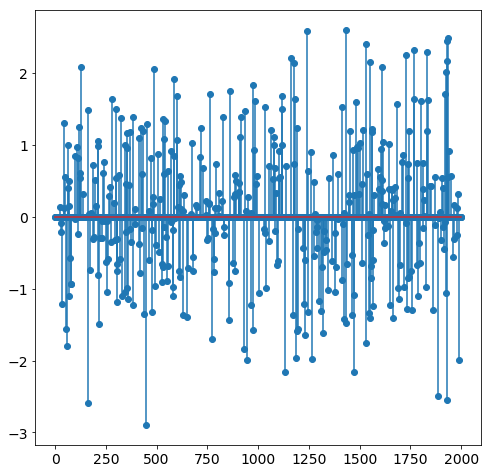

In [3]:
x, F, y = sample_instance(2000, 0.2, 0.5, 1e-5)
plt.stem(x)

In [4]:
def iterate_amp(F, y, var_noise, frac_nonzeros,
                x0=None, max_iter=100, tol=1e-7, verbose=1):
    """Iterates AMP to solve y = Fx, w/ x Bernoulli-Gaussian"""
    
    # Some pre-processing
    size_y, size_x = F.shape
    sqrF = F * F
    
    # Initialize variables
    A = np.ones(size_x)
    B = np.zeros(size_x)
    a = np.zeros(size_x)
    c = np.ones(size_x)
    
    a_old = np.zeros(size_x)
    
    v = np.ones(size_y)
    w = np.copy(y)
    
    mses = np.zeros(max_iter)
    for t in range(max_iter):
        # Store old v and compute new v and w
        v_old = np.copy(v)
        v = sqrF.dot(c)
        w = F.dot(a) - v * ((y - w) / (var_noise + v_old))
        
        # Iterate A and B
        A = sqrF.T.dot(1 / (var_noise + v))
        B = F.T.dot((y - w) / (var_noise + v)) + A * a
        
        # Store old mean and compute new mean/variance
        a_old = np.copy(a)
        a, c = prior(A, B, frac_nonzeros)
        
        # Compute metrics
        diff = np.mean(np.abs(a - a_old))
        mses[t] = np.mean((a - x0) ** 2) if x0 is not None else 0
        
        # Print iteration status on screen
        if verbose:
            print("t = %d, diff = %g; mse = %g" % (t, diff, mses[t]))
        
        # Check for convergence
        if diff < tol:
            break
            
    return mses

In [5]:
def prior(A, B, rho):
    """Compute f and f' for Bernoulli-Gaussian prior"""
    
    # let x = s * t, with s ~ Bernoulli(p) and t ~ N(0, 1); then m = E(t), v = Var(t), p = E(s)
    m = B / (1 + A)
    v = 1 / (1 + A)
    p = rho / (rho + (1 - rho) * np.sqrt(1 + A) * np.exp(-.5 * m ** 2 / v))
    
    # compute E(s * t) and Var(s * t) from E(t), Var(t) and E(s)
    a = p * m
    c = p * v + p * (1 - p) * m ** 2
    return a, c

In [6]:
mses_amp = iterate_amp(F, y, var_noise=1e-5, frac_nonzeros=0.2, x0=x);

t = 0, diff = 0.0398033; mse = 0.172325
t = 1, diff = 0.144805; mse = 0.098441
t = 2, diff = 0.141992; mse = 0.0639177
t = 3, diff = 0.0991968; mse = 0.0407444
t = 4, diff = 0.0669662; mse = 0.0268848
t = 5, diff = 0.0454614; mse = 0.0178901
t = 6, diff = 0.0372369; mse = 0.0121785
t = 7, diff = 0.0278882; mse = 0.00876821
t = 8, diff = 0.0228935; mse = 0.00580281
t = 9, diff = 0.019284; mse = 0.00377963
t = 10, diff = 0.0170755; mse = 0.0022014
t = 11, diff = 0.0144038; mse = 0.00138264
t = 12, diff = 0.0120123; mse = 0.000803358
t = 13, diff = 0.00941466; mse = 0.000445088
t = 14, diff = 0.00756945; mse = 0.000248029
t = 15, diff = 0.0057566; mse = 0.000125473
t = 16, diff = 0.00406548; mse = 6.29563e-05
t = 17, diff = 0.0024762; mse = 3.46423e-05
t = 18, diff = 0.00139796; mse = 1.89512e-05
t = 19, diff = 0.000933051; mse = 1.18642e-05
t = 20, diff = 0.000637904; mse = 9.84183e-06
t = 21, diff = 0.000431823; mse = 8.83734e-06
t = 22, diff = 0.00031091; mse = 8.44828e-06
t = 23, diff

## State evolution

In [7]:
from scipy.integrate import quad

def iterate_se(frac_nonzeros, rows_to_columns, var_noise, max_iter=100, tol=1e-7, verbose=1):
    """Iterates state evolution associated to AMP implementation above"""
    
    # Define function to be integrated at each step
    f = lambda A: lambda z: np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi) * \
            ((1 - frac_nonzeros) * prior(A, np.sqrt(A) * z, frac_nonzeros)[1] + \
             frac_nonzeros * prior(A, np.sqrt(A * (1 + A)) * z, frac_nonzeros)[1])
    
    v = np.zeros(max_iter)
    v[0] = frac_nonzeros
    
    for t in range(max_iter - 1):
        A = rows_to_columns / (var_noise + v[t])
        v[t + 1] = quad(f(A), -10, 10)[0]
        
        diff = np.abs(v[t + 1] - v[t])
        if verbose:
            print("t = %d, diff = %g; v = %g" % (t, diff, v[t + 1]))
            
        if diff < tol:
            break
    
    return v

In [8]:
mses_se = iterate_se(frac_nonzeros=0.2, rows_to_columns=0.5, var_noise=1e-5);

t = 0, diff = 0.0942057; v = 0.105794
t = 1, diff = 0.0377029; v = 0.0680914
t = 2, diff = 0.0211465; v = 0.0469449
t = 3, diff = 0.0137278; v = 0.0332171
t = 4, diff = 0.0096076; v = 0.0236095
t = 5, diff = 0.00698217; v = 0.0166274
t = 6, diff = 0.00514239; v = 0.011485
t = 7, diff = 0.00376954; v = 0.00771542
t = 8, diff = 0.00271023; v = 0.00500519
t = 9, diff = 0.00188795; v = 0.00311724
t = 10, diff = 0.00126128; v = 0.00185596
t = 11, diff = 0.000801748; v = 0.00105421
t = 12, diff = 0.000482362; v = 0.00057185
t = 13, diff = 0.000274055; v = 0.000297795
t = 14, diff = 0.000147184; v = 0.000150611
t = 15, diff = 7.50335e-05; v = 7.55775e-05
t = 16, diff = 3.65645e-05; v = 3.90129e-05
t = 17, diff = 1.71881e-05; v = 2.18248e-05
t = 18, diff = 7.87279e-06; v = 1.3952e-05
t = 19, diff = 3.5468e-06; v = 1.04052e-05
t = 20, diff = 1.58304e-06; v = 8.82216e-06
t = 21, diff = 7.03213e-07; v = 8.11895e-06
t = 22, diff = 3.11674e-07; v = 7.80727e-06
t = 23, diff = 1.37996e-07; v = 7.6692

(0, 30)

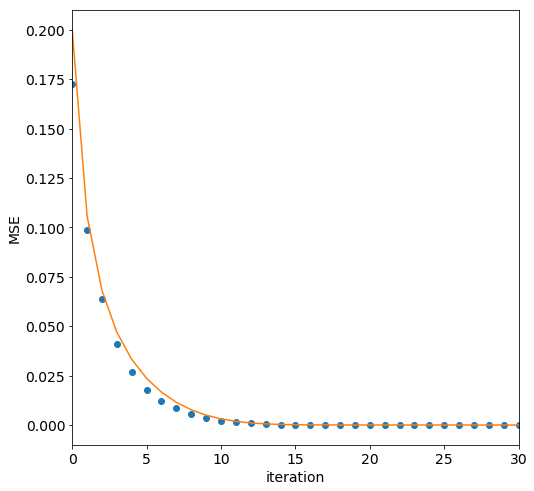

In [9]:
# Compare MSE obtained in AMP and state evolution, *at each iteration*
plt.plot(mses_amp, "o")
plt.plot(mses_se, "-")
plt.ylabel("MSE")
plt.xlabel("iteration")
plt.xlim([0, 30])